In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

In [2]:
# Load datasets
matchups_2007 = pd.read_csv("matchups-2007.csv")
matchups_2008 = pd.read_csv("matchups-2008.csv")
matchups_2009 = pd.read_csv("matchups-2009.csv")

In [3]:
# Combine training datasets
train_df = pd.concat([matchups_2007, matchups_2008], ignore_index=True)

In [4]:
# Use 30% of 2009 data for testing
test_df, _ = train_test_split(matchups_2009, test_size=0.7, random_state=42)


In [5]:
# Define feature columns
player_cols = [f"home_{i}" for i in range(5)] + [f"away_{i}" for i in range(5)]
stat_cols = ["reb_visitor", "dreb_visitor", "oreb_visitor", "to_visitor", "pts_visitor", "pct_visitor"]
target_col = "outcome"

In [6]:
# Create a player mapping dictionary
unique_players = set(train_df[player_cols].values.flatten())
player_mapping = {player: idx for idx, player in enumerate(unique_players)}

def map_players(player_name):
    return player_mapping.get(player_name, -1)  # Assign -1 for unseen players

In [7]:
# Apply mapping to train and test sets
for col in player_cols:
    train_df[col] = train_df[col].map(map_players)
    test_df[col] = test_df[col].map(map_players)

In [8]:
# Feature matrix & target variable
X_train = train_df[player_cols + stat_cols]
y_train = (train_df[target_col] == 1).astype(int)
X_test = test_df[player_cols + stat_cols]
y_test = (test_df[target_col] == 1).astype(int)


In [9]:
# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [10]:
# Train models
rf_model = RandomForestClassifier(n_estimators=200, max_depth=15, min_samples_split=5, random_state=42)
xgb_model = XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, random_state=42, use_label_encoder=False, eval_metric='logloss')
lgbm_model = LGBMClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)


In [11]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, min_samples_split=5, n_estimators=200,
                       random_state=42)

In [12]:
xgb_model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:12:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [13]:
lgbm_model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 18886, number of negative: 35207
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004673 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2492
[LightGBM] [Info] Number of data points in the train set: 54093, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349139 -> initscore=-0.622824
[LightGBM] [Info] Start training from score -0.622824
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

LGBMClassifier(max_depth=6, random_state=42)

In [14]:

# Evaluate models
rf_pred = rf_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)
lgbm_pred = lgbm_model.predict(X_test)

rf_acc = accuracy_score(y_test, rf_pred)
xgb_acc = accuracy_score(y_test, xgb_pred)
lgbm_acc = accuracy_score(y_test, lgbm_pred)

print(f"Random Forest Accuracy: {rf_acc:.4f}")
print(f"XGBoost Accuracy: {xgb_acc:.4f}")
print(f"LightGBM Accuracy: {lgbm_acc:.4f}")

print("\nClassification Report (Random Forest):")
print(classification_report(y_test, rf_pred))

print("\nClassification Report (XGBoost):")
print(classification_report(y_test, xgb_pred))

print("\nClassification Report (LightGBM):")
print(classification_report(y_test, lgbm_pred))


Random Forest Accuracy: 0.7170
XGBoost Accuracy: 0.7212
LightGBM Accuracy: 0.7267

Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.76      0.81      0.78      5038
           1       0.62      0.56      0.59      2884

    accuracy                           0.72      7922
   macro avg       0.69      0.68      0.69      7922
weighted avg       0.71      0.72      0.71      7922


Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       0.75      0.83      0.79      5038
           1       0.64      0.53      0.58      2884

    accuracy                           0.72      7922
   macro avg       0.70      0.68      0.69      7922
weighted avg       0.71      0.72      0.71      7922


Classification Report (LightGBM):
              precision    recall  f1-score   support

           0       0.76      0.83      0.79      5038
           1       0.65      0.55      0.59   

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


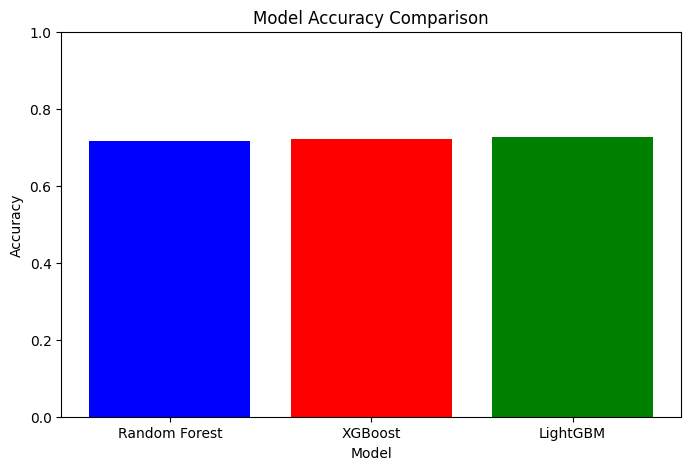

In [15]:
# Generate a comparison plot
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
accuracies = [rf_acc, xgb_acc, lgbm_acc]

plt.figure(figsize=(8, 5))
plt.bar(model_names, accuracies, color=['blue', 'red', 'green'])
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.ylim(0, 1)
plt.show()
